Necessary imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix
from scipy.sparse.csgraph import connected_components
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight

Load the datasets and create a hierarchy_map dictionary

In [ ]:
df = pd.read_csv('product_catalog.csv')

category_map_df = pd.read_csv('product_category_map.csv')
hierarchy_map = category_map_df.set_index('category_id')['parent_category_id'].to_dict()

Function that gets the full path of categories

In [ ]:
def get_full_hierarchy_path(category_id, hierarchy_map):
    path = [category_id]
    while category_id in hierarchy_map and category_id != hierarchy_map[category_id]:  # Avoid infinite loops
        category_id = hierarchy_map[category_id]
        path.append(category_id)
    return path

get_full_hierarchy_path(1, hierarchy_map)

[1, 1499, 3761, 2723, 3898]

- Fill NaN category values with "[-1]"
- Convert categories into a list and then get the full path using the above function
- Put the 'categories_full_path' into a set to get rid of duplicate values

In [ ]:
df = df.fillna("[-1]")

# Ensure the categories column contains lists
df['categories'] = df['categories'].apply(lambda x: eval(x))

# Add full hierarchy paths for each category
df['categories_full_path'] = df['categories'].apply(
    lambda cat_list: [get_full_hierarchy_path(cat, hierarchy_map) for cat in cat_list]
)

# Flatten the paths into a single list of unique categories
df['categories_flat'] = df['categories_full_path'].apply(
    lambda paths: list(set([item for sublist in paths for item in sublist]))
)

# Process 'categories' column as before
df['categories_str'] = df['categories_flat'].apply(
    lambda x: ' '.join(map(str, eval(x))) if isinstance(x, str) else ' '.join(map(str, x))
)

Compute the similarity of each product between each other, construct a similarity matrix

In [ ]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(' '))
category_vectors = vectorizer.fit_transform(df['categories_str'])

# List of numerical attribute columns
numerical_cols = ['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']

# Process numerical attributes
# Ensure there are no missing values in the numerical columns
df[numerical_cols] = df[numerical_cols].fillna(0)

scaler = StandardScaler()
numerical_features = scaler.fit_transform(df[numerical_cols])  # This will be a NumPy array
numerical_features_sparse = csr_matrix(numerical_features)  # Convert to sparse matrix for compatibility

# Combine category vectors with numerical features
combined_features = hstack([category_vectors, numerical_features_sparse])

# Compute the cosine similarity between all combined feature vectors
similarity_matrix = cosine_similarity(combined_features)

# Convert the similarity matrix to a DataFrame for better readability
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df['product_id'],
    columns=df['product_id']
)

similarity_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


product_id,22665,28640,13526,21399,8504,32122,31956,6237,16971,18385,...,8769,28025,20995,20432,5765,12036,22709,32322,19118,16083
product_id,,,,,,,,,,,,,,,,,,,,,
22665,1.000000,-0.255674,0.048623,-0.054197,0.147648,0.036515,0.240801,0.294467,0.103059,0.128844,...,-0.244923,0.146318,-0.061999,0.038158,-0.255674,0.033442,0.114235,-0.064682,-0.069731,0.033658
28640,-0.255674,1.000000,0.164282,0.338537,-0.127390,0.153854,-0.139535,-0.305108,-0.129835,-0.162320,...,0.094947,-0.035776,0.417022,0.293241,1.000000,0.257001,-0.173658,0.365674,0.144869,-0.177594
13526,0.048623,0.164282,1.000000,0.556221,0.028565,-0.085668,0.112982,0.002393,0.120033,0.150065,...,0.031881,0.246590,0.353067,0.289834,0.164282,0.473385,-0.103116,0.266934,-0.062537,-0.107886
21399,-0.054197,0.338537,0.556221,1.000000,0.095311,-0.079486,0.040437,0.038260,0.091079,0.113867,...,0.244684,0.311450,0.652732,0.297973,0.338537,0.261149,-0.027949,0.497881,0.067265,0.075660
8504,0.147648,-0.127390,0.028565,0.095311,1.000000,0.380379,0.289549,0.144713,0.107903,0.134900,...,-0.015823,0.166109,0.103426,0.004219,-0.127390,0.003698,0.316161,0.073377,0.427321,0.425226


Construct the clusters based on the similarity matrix

In [ ]:
threshold = 0.9 # Minimum similarity for products to be in the same cluster

# Create an adjacency matrix where similarity > threshold
adjacency_matrix = (similarity_matrix > threshold).astype(int)

# Use connected components to find groups
n_components, labels = connected_components(csgraph=adjacency_matrix, directed=False)

product_ids = df['product_id'].tolist()

product_clusters = pd.DataFrame({
    'product_id': product_ids,
    'cluster': labels
})

product_clusters['cluster'].value_counts().head()

,count
cluster,
0,30490
6,154
87,53
326,24
268,20


In [ ]:
#Freeing up the memory
df = None
adjacency_matrix = None
similarity_matrix = None
category_vectors = None
hierarchy_map = None
vectorizer = None
similarity_df = None
product_ids = None

In [ ]:

# Load and clean the datasets
df1 = pd.read_csv('product_catalog.csv')
df2 = pd.read_csv('transactions.csv')
df1 = df1.dropna()
df2 = df2.dropna()
# Add clusters to df1 and df2
df1_with_clusters = df1.merge(product_clusters, on='product_id', how='left')
df2_with_clusters = df2.merge(product_clusters, on='product_id', how='left')

# Replace product_id with cluster
df1_with_clusters['product_id'] = df1_with_clusters['cluster']
df2_with_clusters['product_id'] = df2_with_clusters['cluster']

# Drop the original cluster column (optional, for cleanliness)
df1_with_clusters = df1_with_clusters.drop(columns=['cluster'])
df2_with_clusters = df2_with_clusters.drop(columns=['cluster'])

# Keep the first instance of each product_id
df1_with_clusters = df1_with_clusters.drop_duplicates(subset='product_id', keep='first')

# Merge the two dataframes on the modified product_id (now cluster_id)
df_with_clusters = df2_with_clusters.merge(df1_with_clusters, on='product_id', how='inner')

df1 = None
df2 = None
df1_with_clusters = None
df2_with_clusters = None


df_with_clusters.sort_values(by=['customer_id','product_id','purchase_date'], inplace=True)
df_with_clusters.reset_index(drop=True, inplace=True)

df_with_clusters['purchase_date'] = pd.to_datetime(df_with_clusters['purchase_date'])

Combining records from the purchases made by a customer on the same day and on the same product.

In [ ]:
# Group by the columns identifying duplicates and sum the 'quantity' column
df_with_clusters = (
    df_with_clusters.groupby(['customer_id', 'product_id', 'purchase_date'], as_index=False)
    .agg({
        'quantity': 'sum',  # Sum the quantities
        'manufacturer_id': 'first',
        'attribute_1': 'first',
        'attribute_2': 'first',
        'attribute_3': 'first',
        'attribute_4': 'first',
        'attribute_5': 'first',
        'categories': 'first'
    })
)


  Calculating the difference between subsequent purchases made by the same customer on the same product to compute weeks which will be used as the label.

In [ ]:
df_with_clusters['weeks'] = df_with_clusters.groupby(by=['customer_id','product_id'])['purchase_date'].diff().dt.days/7
df_with_clusters['weeks'] = np.ceil(df_with_clusters['weeks'])

df_with_clusters['weeks'].value_counts().head()

# Mark the last purchase for each customer-product combination
df_with_clusters['is_last_purchase'] = ~df_with_clusters.duplicated(['customer_id', 'product_id'], keep='last')

# Fill 'weeks' with 0 for the last purchase where it is NaN
df_with_clusters.loc[df_with_clusters['is_last_purchase'] & df_with_clusters['weeks'].isna(), 'weeks'] = 0

# Calculate the average quantity for each customer-product group
average_quantities = df_with_clusters.groupby(['customer_id', 'product_id'])['quantity'].transform('mean')

# Assign the average quantity to all rows
df_with_clusters['quantity'] = average_quantities

# Keep only the last purchase
df_with_clusters = df_with_clusters[~(df_with_clusters['weeks'].isna() & ~df_with_clusters['is_last_purchase'])].reset_index(drop=True)

# Drop the helper column
df_with_clusters = df_with_clusters.drop(columns='is_last_purchase')
df_with_clusters.head()

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,weeks
0,0,0,2020-08-03,1.875,861,4,0,490,2,66,"[2890, 855, 3908, 3909]",9.0
1,0,0,2020-10-09,1.875,861,4,0,490,2,66,"[2890, 855, 3908, 3909]",10.0
2,0,0,2020-11-20,1.875,861,4,0,490,2,66,"[2890, 855, 3908, 3909]",6.0
3,0,0,2020-12-04,1.875,861,4,0,490,2,66,"[2890, 855, 3908, 3909]",2.0
4,0,0,2020-12-11,1.875,861,4,0,490,2,66,"[2890, 855, 3908, 3909]",1.0


In [ ]:
df_with_clusters['categories_flat'] = df_with_clusters['categories'].apply(
    lambda cat_list: list(set([item for sublist in cat_list for item in sublist])) if isinstance(cat_list, list) and all(isinstance(sublist, list) for sublist in cat_list)
    else cat_list  # Handle cases where 'categories' is not a list of lists
)

Features in the dataset and custom features which we created for better generalization.

In [ ]:
#### month
df_with_clusters['month'] = df_with_clusters['purchase_date'].dt.month

### Recency and Frequency
# Recency
rfm = df_with_clusters.groupby('customer_id')['purchase_date'].max().reset_index()
rfm['recency'] = (df_with_clusters['purchase_date'].max() - rfm['purchase_date']).dt.days

# Frequency
frequency = df_with_clusters.groupby('customer_id')['quantity'].count().reset_index(name='frequency')
rfm = pd.merge(rfm, frequency, on='customer_id')

# Merge back to the main DataFrame
df_with_clusters = pd.merge(df_with_clusters, rfm[['customer_id', 'recency', 'frequency']], on='customer_id', how='left')

### total_quantity_purchased
total_quantity = df_with_clusters.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index(name='total_quantity_purchased')
df_with_clusters = df_with_clusters.merge(total_quantity, on=['customer_id', 'product_id'], how='left')

#### avg_purchase_interval
# Calculate differences in days between purchases
df_with_clusters['days_since_last_purchase'] = df_with_clusters.groupby(['customer_id', 'product_id'])['purchase_date'].diff().dt.days

# Compute average purchase interval
avg_purchase_interval = df_with_clusters.groupby(['customer_id', 'product_id'])['days_since_last_purchase'].mean().reset_index(name='avg_purchase_interval')
df_with_clusters = df_with_clusters.merge(avg_purchase_interval, on=['customer_id', 'product_id'], how='left')

#### customer_purchase_count
customer_purchase_count = df_with_clusters.groupby('customer_id')['quantity'].count().reset_index(name='customer_purchase_count')
df_with_clusters = df_with_clusters.merge(customer_purchase_count, on='customer_id', how='left')


#### product_reorder_rate
# Count of customers who have purchased the product more than once
repeat_customers = df_with_clusters.groupby(['product_id', 'customer_id']).size().reset_index(name='purchase_times')
repeat_customers_flag = repeat_customers[repeat_customers['purchase_times'] > 1].groupby('product_id')['customer_id'].count().reset_index(name='repeat_customer_count')

# Total unique customers per product
total_customers = df_with_clusters.groupby('product_id')['customer_id'].nunique().reset_index(name='total_customers')

# Merge and compute reorder rate
product_reorder_rate = pd.merge(total_customers, repeat_customers_flag, on='product_id', how='left').fillna(0)
product_reorder_rate['product_reorder_rate'] = product_reorder_rate['repeat_customer_count'] / product_reorder_rate['total_customers']

df_with_clusters = df_with_clusters.merge(product_reorder_rate[['product_id', 'product_reorder_rate']], on='product_id', how='left')

### purchase_count
customer_product_purchases = df_with_clusters.groupby(['customer_id', 'product_id'])['quantity'].count().reset_index(name='purchase_count')
df_with_clusters = df_with_clusters.merge(customer_product_purchases, on=['customer_id', 'product_id'], how='left')

### customer_purchase_frequency
# Calculate the total number of purchases and the time span
customer_purchases = df_with_clusters.groupby('customer_id')['purchase_date'].agg(['min', 'max', 'count']).reset_index()
customer_purchases['customer_time_span'] = (customer_purchases['max'] - customer_purchases['min']).dt.days + 1
customer_purchases['customer_purchase_frequency'] = customer_purchases['count'] / customer_purchases['customer_time_span']

# Merge back to the main DataFrame
df_with_clusters = pd.merge(df_with_clusters, customer_purchases[['customer_id', 'customer_purchase_frequency']], on='customer_id', how='left')

### day_of_week
# Day of the week (0=Monday, 6=Sunday)
df_with_clusters['day_of_week'] = df_with_clusters['purchase_date'].dt.dayofweek

### is_weekend
# Weekend indicator
df_with_clusters['is_weekend'] = df_with_clusters['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

### product_total_purchases
# Total purchases per product
product_popularity = df_with_clusters.groupby('product_id')['quantity'].sum().reset_index(name='product_total_purchases')

# Merge back to the main DataFrame
df_with_clusters = pd.merge(df_with_clusters, product_popularity, on='product_id', how='left')

### product_days_since_last_purchase
product_last_purchase = df_with_clusters.groupby('product_id')['purchase_date'].max().reset_index(name='product_last_purchase_date')
product_last_purchase['product_days_since_last_purchase'] = (df_with_clusters['purchase_date'].max() - product_last_purchase['product_last_purchase_date']).dt.days

# Merge back to the main DataFrame
df_with_clusters = pd.merge(df_with_clusters, product_last_purchase[['product_id', 'product_days_since_last_purchase']], on='product_id', how='left')

### cumulative_quantity
df_with_clusters['cumulative_quantity'] = df_with_clusters.groupby(['customer_id', 'product_id'])['quantity'].cumsum()

## cumulative_purchases
df_with_clusters['cumulative_purchases'] = df_with_clusters.groupby(['customer_id', 'product_id']).cumcount() + 1

## customer_tenure
# First purchase date per customer
first_purchase = df_with_clusters.groupby('customer_id')['purchase_date'].min().reset_index()
first_purchase.rename(columns={'purchase_date': 'first_purchase_date'}, inplace=True)

# Merge to main DataFrame
df_with_clusters = pd.merge(df_with_clusters, first_purchase, on='customer_id', how='left')

# Calculate tenure
df_with_clusters['customer_tenure'] = (df_with_clusters['purchase_date'] - df_with_clusters['first_purchase_date']).dt.days

## average_cart_size
# Average cart size per customer
average_cart_size = df_with_clusters.groupby('customer_id')['quantity'].mean().reset_index(name='average_cart_size')

# Merge back to main DataFrame
df_with_clusters = pd.merge(df_with_clusters, average_cart_size, on='customer_id', how='left')

## total_categories_purchased
# Ensure 'categories_flat' is a list
df_with_clusters['categories_flat'] = df_with_clusters['categories_flat'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

# Total unique categories purchased by customer
customer_categories = df_with_clusters.groupby('customer_id')['categories_flat'].apply(lambda x: set([cat for sublist in x for cat in sublist])).reset_index()
customer_categories['total_categories_purchased'] = customer_categories['categories_flat'].apply(len)

# Merge back
df_with_clusters = pd.merge(df_with_clusters, customer_categories[['customer_id', 'total_categories_purchased']], on='customer_id', how='left')

### cust_prod_interaction_freq
# Number of times a customer purchased a product
cust_prod_interact = df_with_clusters.groupby(['customer_id', 'product_id'])['purchase_date'].count().reset_index(name='cust_prod_interaction_freq')

# Merge back
df_with_clusters = pd.merge(df_with_clusters, cust_prod_interact, on=['customer_id', 'product_id'], how='left')

## product_popularity_rank
# Calculate total sales per product
product_sales = df_with_clusters.groupby('product_id')['quantity'].sum().reset_index(name='total_sales')

# Rank products by sales
product_sales['product_popularity_rank'] = product_sales['total_sales'].rank(ascending=False)

# Merge back to the main DataFrame
df_with_clusters = df_with_clusters.merge(
    product_sales[['product_id', 'product_popularity_rank']],
    on='product_id',
    how='left'
)

### recent_purchase_ratio
# Define a recent period
recent_period_days = 28
latest_date = df_with_clusters['purchase_date'].max()
recent_threshold = latest_date - pd.Timedelta(days=recent_period_days)

# Total purchases in recent period per customer
recent_purchases = df_with_clusters[df_with_clusters['purchase_date'] >= recent_threshold]
recent_purchase_counts = recent_purchases.groupby('customer_id')['quantity'].sum().reset_index(name='recent_purchase_quantity')

# Total purchases per customer
total_purchase_counts = df_with_clusters.groupby('customer_id')['quantity'].sum().reset_index(name='total_purchase_quantity')

# Calculate recent purchase ratio
purchase_ratio = total_purchase_counts.merge(recent_purchase_counts, on='customer_id', how='left')
purchase_ratio['recent_purchase_ratio'] = purchase_ratio['recent_purchase_quantity'] / purchase_ratio['total_purchase_quantity']
purchase_ratio['recent_purchase_ratio'].fillna(0, inplace=True)

# Merge back to the main DataFrame
df_with_clusters = df_with_clusters.merge(
    purchase_ratio[['customer_id', 'recent_purchase_ratio']],
    on='customer_id',
    how='left'
)

### is_recurring_purchase
# Identify customers who have purchased the same product more than once
repeat_purchases = df_with_clusters.groupby(['customer_id', 'product_id'])['purchase_date'].nunique().reset_index(name='purchase_times')
repeat_purchases['is_recurring_purchase'] = (repeat_purchases['purchase_times'] > 1).astype(int)

# Merge back to the main DataFrame
df_with_clusters = df_with_clusters.merge(
    repeat_purchases[['customer_id', 'product_id', 'is_recurring_purchase']],
    on=['customer_id', 'product_id'],
    how='left'
)

### cust_prod_affinity_score
# Calculate total quantity of the product purchased by the customer
cust_prod_total_quantity = df_with_clusters.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index(name='cust_prod_total_quantity')

# Calculate total quantity purchased by the customer across all products
customer_total_quantity = df_with_clusters.groupby('customer_id')['quantity'].sum().reset_index(name='customer_total_quantity')

# Merge to calculate affinity score
cust_prod_affinity = cust_prod_total_quantity.merge(customer_total_quantity, on='customer_id')
cust_prod_affinity['cust_prod_affinity_score'] = cust_prod_affinity['cust_prod_total_quantity'] / cust_prod_affinity['customer_total_quantity']

# Merge back to the main DataFrame
df_with_clusters = df_with_clusters.merge(
    cust_prod_affinity[['customer_id', 'product_id', 'cust_prod_affinity_score']],
    on=['customer_id', 'product_id'],
    how='left'
)

In [ ]:
# Update categorical features list
categorical_features = [
    'customer_id',
    'product_id',
    'attribute_2',
    'attribute_3',
    'attribute_4',
    'attribute_5',
    'manufacturer_id',
    'month',
    'day_of_week',
    'product_popularity_rank',
    'is_recurring_purchase'
]

# Update numerical features list
numerical_features = [
    'quantity',
    'recency',
    'frequency',
    'avg_purchase_interval',
    'total_quantity_purchased',
    'customer_purchase_count',
    'product_reorder_rate',
    'purchase_count',
    'customer_purchase_frequency',
    'product_total_purchases',
    'product_days_since_last_purchase',
    'cumulative_quantity',
    'cumulative_purchases',
    'customer_tenure',
    'average_cart_size',
    'total_categories_purchased',
    'cust_prod_interaction_freq',
    'recent_purchase_ratio',
    'cust_prod_affinity_score'
]

for col in categorical_features:
    df_with_clusters[col] = df_with_clusters[col].astype('category')
    df_with_clusters[col] = df_with_clusters[col].astype(str)
    df_with_clusters[col] = df_with_clusters[col].fillna('Unknown')

Applying Principal Component Analysis (PCA) to numerical features

In [ ]:
# Extract numerical features
X_numerical = df_with_clusters[numerical_features].fillna(0)

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Apply PCA
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into DataFrame
pca_columns = [f'pca_{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Merge PCA components back to the main DataFrame
df_with_clusters.reset_index(drop=True, inplace=True)
df_with_clusters = pd.concat([df_with_clusters, X_pca_df], axis=1)

numerical_features = pca_columns

Training the Catboost model with different parameters to find the best one using randomized search.

This model predicts whether the customers repurchase in the following four weeks or not.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'verbose': 0, 'task_type': 'GPU', 'random_strength': 1, 'random_seed': 42, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 500, 'devices': '0', 'depth': 6, 'class_weights': {0: 0.7917878499166343, 1: 1.356786874681131}, 'border_count': 128, 'bagging_temperature': 1.0}
Best cross-validation F1-score:  0.760940988548733


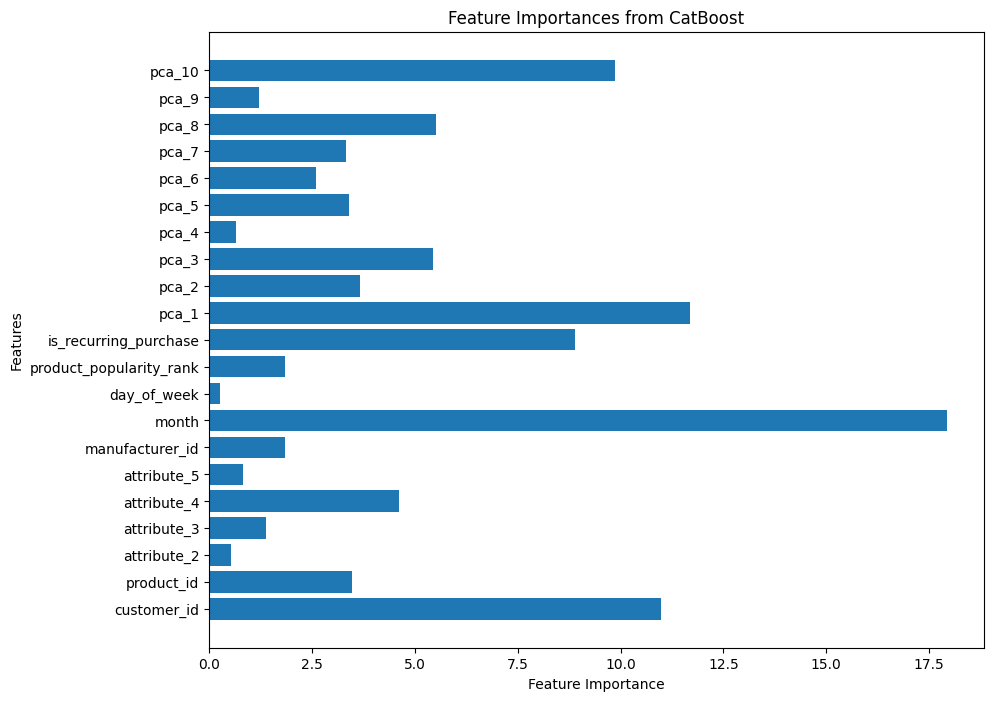

In [ ]:
# Prepare features and target
X_categorical = df_with_clusters[categorical_features].copy()
X_numerical = df_with_clusters[numerical_features].copy()
X = pd.concat([X_categorical, X_numerical], axis=1)

# Target variable
y = df_with_clusters['weeks'].apply(lambda x: 1 if x in [1, 2, 3, 4] else 0)


# Combine X and y to include 'purchase_date' for sorting
data = X.copy()
data['y'] = y
data['purchase_date'] = df_with_clusters['purchase_date']

# Sort data by 'purchase_date' to maintain temporal order
data.sort_values('purchase_date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Separate features, target, and purchase dates after sorting
X = data.drop(columns=['y', 'purchase_date'])
y = data['y']
purchase_dates = data['purchase_date']

# Define categorical feature indices for CatBoost
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Convert categorical features to string type (CatBoost handles them natively)
for col in categorical_features:
    X[col] = X[col].astype(str)

# Calculate class weights for imbalanced classification
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, class_weights))

# Initialize TimeSeriesSplit cross-validator
n_splits = 5  # Adjust the number of splits to balance computation time and performance
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the parameter distributions to sample from
param_dist = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [1, 2],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'border_count': [32, 64, 128],
    'class_weights': [class_weights_dict],
    'random_seed': [42],
    'verbose': [0],
    'task_type': ['GPU'],
    'devices': ['0']
}

# Initialize CatBoost model
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=categorical_features_indices,
    early_stopping_rounds=50
)

# Define custom scoring function for cross-validation
f1_scorer = make_scorer(f1_score, pos_label=1)

# Initialize RandomizedSearchCV with TimeSeriesSplit
n_iter = 20  # Adjust n_iter to control the number of parameter settings tried
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    cv=tscv,
    scoring=f1_scorer,
    n_jobs=1,
    n_iter=n_iter,
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
random_search.fit(X, y)

# Display best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation F1-score: ", random_search.best_score_)

# Retrieve the best model
best_model1 = random_search.best_estimator_

# Now, retrain the best model on the entire dataset
best_model1.fit(X, y, verbose=False)

# Plot feature importance
feature_importances = best_model1.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from CatBoost")
plt.show()

This model predicts the repurchase dates of the customers which are described by the n-th week of the month.


In [ ]:
# Prepare data for the second model
df_used = df_with_clusters[(df_with_clusters['weeks'] <= 4) & (df_with_clusters['weeks'] != 0)].copy()

# Convert categorical variables to strings and fill missing values
for col in categorical_features:
    df_used[col] = df_used[col].astype(str)
    df_used[col] = df_used[col].fillna('Unknown')

# Prepare features and target
X_categorical = df_used[categorical_features].copy()
X_numerical = df_used[numerical_features].copy()
X = pd.concat([X_categorical, X_numerical], axis=1)
y = df_used['weeks']

# Combine X and y to include 'purchase_date' for sorting
data = X.copy()
data['y'] = y
data['purchase_date'] = df_used['purchase_date']

# Sort data by 'purchase_date' to maintain temporal order
data.sort_values('purchase_date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Separate features, target, and purchase dates after sorting
X = data.drop(columns=['y', 'purchase_date'])
y = data['y']
purchase_dates = data['purchase_date']

# Define categorical feature indices for CatBoost
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Initialize TimeSeriesSplit cross-validator
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Calculate class weights for imbalanced classification
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = dict(zip(classes, class_weights))

# Define the parameter distributions to sample from
param_dist = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [1, 2],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'border_count': [32, 64, 128],
    'class_weights': [class_weights_dict],
    'random_seed': [42],
    'verbose': [0],
    'task_type': ['GPU'],
    'devices': ['0']
}

# Initialize the CatBoost model
cat_model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    cat_features=categorical_features_indices,
    early_stopping_rounds=50
)

# Define custom scoring function for cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with TimeSeriesSplit
n_iter = 10
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    cv=tscv,
    scoring=f1_scorer,
    n_jobs=1,
    n_iter=n_iter,
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
random_search.fit(X, y)

# Display best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation Weighted F1-score: ", random_search.best_score_)

# Retrieve the best model
best_model2 = random_search.best_estimator_

# Now, retrain the best model on the entire dataset
best_model2.fit(X, y)

# Plot feature importance
feature_importances = best_model2.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from CatBoost")
plt.show()